In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from numba import cuda

import os
import glob
import time
import IPython.display

from lat_class_parallel import *
"""
from tqdm.notebook import tqdm
"""

'\nfrom tqdm.notebook import tqdm\n'

In [2]:
kl_sim = lattice_sim()

[2 2 3 3]
Setting worm to tail: [[1 0]
 [1 2]], head: [[[1 0]
  [0 0]]

 [[1 2]
  [0 0]]]

with k_delta: [-1 -1]



In [3]:
seed = 42
np.random.seed(seed)

Iteration 2


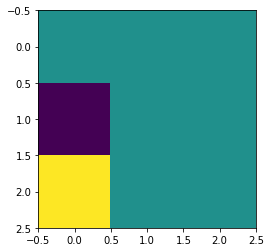

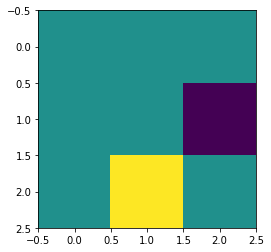

before move
head: 
[[[2 0]
  [2 0]]

 [[2 1]
  [2 1]]]
tail:
[[1 0]
 [1 2]]
proposing move_dim:
 [1 1]
proposing sign:
 [1 0]
proposing move_i:
 [3 1]
transforming link index
possibly invalid link index:
 [[1 2 0]
 [1 2 1]]
valid link index:
 [[1 2 0]
 [1 2 1]]
proposing new heads:
 [[1 2]
 [1 0]]
dk: [ 1 -1]
df: [2 2]
counting collisions
creating new collision for 0
creating new collision for 1
raw collisions:
[]
rectangular collisions:
[]
collisions:
[[2 2 2 2]]
containing worms: []
not containing worms: []
Starting Metropolis algorithm for all worms
dk: [ 1 -1]
df: [2 2]
Calculating acceptance probability for all 2 worms
k_old [0 0]
dk [ 1 -1]
k_prop [ 1 -1]
df [2 2]
df_new_head [0 0]
p [1 1]
accepted
worm 0 adjusts link [1 2 0]
k before 0
k after 1
f before 2
f after 4
head before [2 0]
head after [1 2]
accepted
worm 1 adjusts link [1 2 1]
k before 0
k after -1
f before 0
f after 2
head before [2 1]
head after [1 0]
after move
head: 
[[[1 2]
  [1 2]]

 [[1 0]
  [1 0]]]
tail:
[[1 0]

In [ ]:
"""main worm loop"""
num_iter = 20

max_iter = 10


finished = False

#limit the number of iteration/worms
for i in range(num_iter):
    print(f"Iteration {i}")
        
    for i_worm in range(kl_sim.num_worms):
        kl_sim.print_env_worm(kl_sim.lat_size, kl_sim.head[i_worm,0], kl_sim.tail[i_worm])
    
    print("before move")
    print("head: ")
    head = kl_sim.head
    tail = kl_sim.tail
    print(f"{head}")
    print("tail:")
    print(f"{tail}")
        
    ##randomly choose moves
    """not updating k_change in class!!!"""
    #(move_dim, move_sign, move_i, move_set, moves, head, worm_link_coord, k_delta, dk, df, k_change, f_change, num_worms, lat_size, dim)
    kl_sim.propose_moves(
        kl_sim.move_dim,
        kl_sim.move_sign,
        kl_sim.move_i,
        kl_sim.move_set,
        kl_sim.moves,
        kl_sim.head,
        kl_sim.worm_link_coord,
        kl_sim.k_delta,
        kl_sim.k_links,
        kl_sim.dk, 
        kl_sim.df,
        kl_sim.k_change,
        kl_sim.f_change,
        kl_sim.num_worms,
        kl_sim.lat_size,
        kl_sim.dim
    )
        
    ##check collisions!
    #head, hoc_dist_ij, lc_dist_ij, num_worms, np_collisions, collision_worms, non_collision_worms, lc_hoc_bool):
    kl_sim.count_collisions(
        kl_sim.head,
        kl_sim.hoc_dist_ij,
        kl_sim.lc_dist_ij,
        kl_sim.num_worms,
        kl_sim.collisions,
        kl_sim.collision_worms,
        kl_sim.non_collision_worms,
        kl_sim.lc_hoc_bool        
    )
        
    print(f"collisions:\n{kl_sim.collisions}")
    print(f"containing worms: {kl_sim.collision_worms}")
    print(f"not containing worms: {kl_sim.non_collision_worms}")

    ##chekc whether there actually are any collisions
    if len(kl_sim.collision_worms) > 0:
        ##yes there are!
        ##sample these first
        ##sample_k_worm_collision_queues(collisions, l_links, k_links, mu, head, tail, worm_link_coord, dk, df, W, f, num_worms)
        kl_sim.sample_k_worm_collision_queues(
            kl_sim.collisions,
            kl_sim.l_links,
            kl_sim.k_links,
            kl_sim.mu,
            kl_sim.head,
            kl_sim.tail,
            kl_sim.worm_link_coord,
            kl_sim.dk,
            kl_sim.df,
            kl_sim.W,
            kl_sim.f,
            kl_sim.worm_closed,
            kl_sim.num_worms
        )
        ##set the changes of sampled collision worms to zero
        ##for the next step (sample ALL worms including these, their effect will be zero nonetheless
        ##because the change associated with them is 0)
        """DONT UNCOMMENT"""
        kl_sim.set_df_dk_zero(kl_sim.df, kl_dim.dk, kl_sim.collision_worms)
            
    ##sample ALL worms
    ##sample_k_worm_all(l_links, k_links, mu, head, tail, worm_link_coord, i_worm, dk, df, W, f, num_worms)
    ##(l_links, k_links, mu, head, tail, worm_link_coord, dk, df, W, f, worm_closed, num_worms)
    kl_sim.sample_k_worm_all(
        kl_sim.l_links,
        kl_sim.k_links,
        kl_sim.mu,
        kl_sim.head,
        kl_sim.tail,
        kl_sim.worm_link_coord,
        kl_sim.dk,
        kl_sim.df,
        kl_sim.W,
        kl_sim.f,
        kl_sim.worm_closed,
        kl_sim.num_worms
    )
        
    print("after move")
    print("head: ")
    head = kl_sim.head
    tail = kl_sim.tail
    print(f"{head}")
    print("tail:")
    print(f"{tail}")
        
        
    input("Press Enter to continue...")
    time.sleep(1.0)
    IPython.display.clear_output(wait=True)
    
    closed_i_worms = [i for i in range(kl_sim.num_worms) if kl_sim.worm_closed[i_worm] == True]
    if i < max_iter:
        ##reset finished worms
        for closed_i_worm in closed_i_worms:
            ##head==tail!
            ##reset worm
            kl_sim.reset_worm(kl_sim.tail, kl_sim.head, kl_sim.worm_link_coord, closed_i_worm, kl_sim.k_delta, kl_sim.lat_size, kl_sim.dim)
                
        
    else:   
        ##dont reset worms, but  remove them!
        ##decrease number of worms kl_sim.num_worms
        ##reshape head, tail, dk, df, p
        open_worms = []
        new_num_worms = kl_sim.num_worms - len(closed_i_worms)
        for i_worm in closed_i_worms:
            ##remove this worm
            pass
                
            
    input("Press Enter to continue...")
    time.sleep(1.0)
    IPython.display.clear_output(wait=True)

In [ ]:
"""
What is missing?
Save df0 when staring worms
Set df correctly
Check for tails and accomodate for df0
f update is not working (indexing problem?)
p is not correctly drawn?
if n_iter is exceeded, remove worms and shrink the worm arrays
"""